# Peter Moss Acute Myeloid / Lymphoblastic Leukemia AI Research Project

**Exploring novel convolutional network architechture to build a classification system for better assistance in diagonosing Acute Lymphoblastic Leukemia in blood cells.**

![Peter Moss Acute Myeloid / Lymphoblastic Leukemia AI Research Project](https://www.PeterMossAmlAllResearch.com/media/images/banner.png)

## Introduction

This notebook explores a novel convolutional network architechture as discussed in the following research paper to build a classification system for better assistance in diagonosing Acute Lymphoblastic Leukemia in blood cells.

Authors: Peter Moss AML/ALL AI Research Project team member and Student Program Co-Manager, [Amita Kapoor](https://www.petermossamlallresearch.com/team/amita-kapoor/profile "Amita Kapoor"), and Student Program student, [Taru Jain](https://www.petermossamlallresearch.com/students/student/taru-jain/profile "Taru Jain").

# ALL Image Database for Image Processing

![Acute Lymphoblastic Leukemia Image Database for Image Processing](https://github.com/AMLResearchProject/AML-ALL-Detection-System/raw/master/Classifiers/Movidius/NCS/Tensorflow/V1/Media/Images/slides.png)
_Fig 1. Samples of augmented data generated using the Acute Lymphoblastic Leukemia Image Database for Image Processing dataset._

The [Acute Lymphoblastic Leukemia Image Database for Image Processing](https://homes.di.unimi.it/scotti/all/) dataset created by [Fabio Scotti, Associate Professor Dipartimento di Informatica, Università degli Studi di Milano](https://homes.di.unimi.it/scotti/) is used in this notebook.

- Here, ALL_IDB2 version of the dataset has been used
- This dataset is completely balanced with equal number of samples in both the classes.

Although in the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") paper the ALL_IDB1 dataset is used, in this notebook you will use the ALL_IDB2 dataset.

## Data Augmentation

Data augmentation ensures that data is large enough and model extracts features efficiently without overfitting and therefore we have analysed two types of data augmentation techniques in this notebook.

* Techniques used in the research paper discussing the following parameters:

   1. Grayscaling of image
   2. Horizontal reflection
   3. Vertical reflection
   4. Gaussian Blurring
   5. Histogram Equalization
   6. Rotation
   7. Translation
   8. Shearing
   
(Using these methods, the dataset size increased from 260 images to 2340 images)
   
* Keras in-built ImageDataGenerator

**The dataset was split into 80% and 20% for training and testing respectively.**

# Present Analysis Results 
The results of our present analysis are:

| Data Augmentation    | Accuracy   | Precision   | Recall   |  ROC |
|---|---|---|---|--|
| Used in paper   | 91%  | 0.93  | 0.88  | 0.97  |
| Keras ImageDataGenerator    |  76% | 0.74  |  0.79 | 0.82 |  
  
  
**This result has been recorded for maximum number of epochs that model could be trained for without overfitting**

**We can infer that the augmentation used in the paper outperforms the in-built augmentation technique used by Keras**

# Clone Peter Moss AML & ALL Classifiers Repository

First of all you should clone the [AML & ALL Classifiers](https://github.com/AMLResearchProject/AML-ALL-Classifiers/ "AML & ALL Classifiers") repo to your device. To do this you can navigate to the location you want to clone the repository to on your device using terminal (cd Your/Clone/Location), and then use the following command:

```
  $ git clone https://github.com/AMLResearchProject/AML-ALL-Classifiers.git
```

Once you have used the command above you will see a directory called **AML-ALL-Classifiers** in the location you chose to clone the repo to. In terminal, navigate to the **AML-ALL-Classifiers/Python/_Keras/QuantisedCode** directory, this is your project root directory.

# Upload Project Root To Google Drive
Now you need to upload the project root to your Google Drive.

# Detailed Implementation
Below is the detailed code implementation of this research paper 

In [0]:
from google.colab import files
files.upload()

Saving ALL_Data2.zip to ALL_Data2.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('ALL_Data2.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

ALL_Data2.zip  logs	   models	tensorflow-for-poets-2	weights.h5
img	       model.json  sample_data	TF_Model		weights.tflite


In [0]:
!pip install keras_metrics

## **Load required packages**

In [0]:
from pathlib import Path
import glob
import random
import cv2
from numpy.random import seed
from tensorflow import set_random_seed
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
from skimage import io
from skimage import transform as tm
import seaborn as sns
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input,GaussianNoise
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras_metrics
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [0]:
# for consistemt results across multiple executions
seed(3)
set_random_seed(3)

## Reading data and inserting into a dataframe

In [0]:
images_dir = Path('img')
images = images_dir.glob("*.tif")

train_data = []
counter = 0

for img in images:
  counter += 1
  if counter <= 130:    
    train_data.append((img,1))    
  else:    
    train_data.append((img,0))
    
train_data = pd.DataFrame(train_data,columns=['image','label'],index = None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.tail()

,image,label
255,img/Im237_0.tif,1
256,img/Im032_1.tif,0
257,img/Im131_0.tif,0
258,img/Im108_1.tif,0
259,img/Im078_1.tif,0


In [0]:
len(train_data)

260

## Data Exploration and Augmentation as presented in the paper

### 8 augmentation techniques have been used here
1. Grayscaling of image
2. Horizontal reflection 
3. Vertical reflection
4. Gaussian Blurring 
5. Histogram Equalization
6. Rotation
7. Translation
8. Shearing

In [0]:
# histogram equalization function
def hist(img):
  
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result

In [0]:
# function to perform rotation on an image
def rotation(img):
  rows,cols = img.shape[0],img.shape[1]
  randDeg = random.randint(-180, 180)
  matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
  rotated = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(144, 159, 162))
  return rotated     

In [0]:
# function to perform shearing of an image
def shear(img):
  # Create Afine transform
  afine_tf = tm.AffineTransform(shear=0.5)

  # Apply transform to image data
  modified = tm.warp(img, inverse_map=afine_tf)
  
  return modified

In [0]:
def aug_method(dataframe,dim,method):
  
  if method == 'paper':    
    n = len(dataframe)

    data = np.zeros((n*9,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n*9,2),dtype = np.float32)

    count = 0

    for j in range(0,n):

      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']

      encoded_label = np_utils.to_categorical(label, num_classes=2)

      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))

      if img.shape[2]==1:

        img = np.dstack([img, img, img])

      orig_img = img.astype(np.float32)/255.

      data[count] = orig_img
      labels[count] = encoded_label      
      
      aug_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      aug_img2 = cv2.flip(img, 0) 
      aug_img3 = cv2.flip(img,1)
      aug_img4 = ndimage.gaussian_filter(img, sigma= 5.11)
      aug_img5 = hist(img)
      aug_img6 = rotation(img)
      aug_img7 = cv2.warpAffine(img, np.float32([[1, 0, 84], [0, 1, 56]]), (img.shape[0], img.shape[1]),
                                  borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162))
      aug_img8 = shear(img)

      aug_img1 = np.dstack([aug_img1, aug_img1, aug_img1])

      aug_img1 = aug_img1.astype(np.float32)/255.                 
      aug_img2 = aug_img2.astype(np.float32)/255.
      aug_img3 = aug_img3.astype(np.float32)/255. 
      aug_img4 = aug_img4.astype(np.float32)/255.
      aug_img5 = aug_img5.astype(np.float32)/255.
      aug_img6 = aug_img6.astype(np.float32)/255.
      aug_img7 = aug_img7.astype(np.float32)/255.
      aug_img8 = aug_img8.astype(np.float32)/255.

      data[count+1] = aug_img1
      labels[count+1] = encoded_label
      data[count+2] = aug_img2
      labels[count+2] = encoded_label
      data[count+3] = aug_img3
      labels[count+3] = encoded_label
      data[count+4] = aug_img4
      labels[count+4] = encoded_label
      data[count+5] = aug_img5
      labels[count+5] = encoded_label
      data[count+6] = aug_img5
      labels[count+6] = encoded_label
      data[count+7] = aug_img5
      labels[count+7] = encoded_label
      data[count+8] = aug_img5
      labels[count+8] = encoded_label

      count +=9
      
  elif method == 'keras':    
    n = len(dataframe)
  
    data = np.zeros((n,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n,2),dtype = np.float32)  
  
    count = 0  
    
    for j in range(0,n):
    
      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']
      
      encoded_label = np_utils.to_categorical(label, num_classes=2)
            
      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))
      
      if img.shape[2]==1:
        img = np.dstack([img, img, img])
            
      orig_img = img.astype(np.float32)/255.
                        
      data[count] = orig_img
      labels[count] = encoded_label
    
      count +=1   
      
  return data,labels                  

In [0]:
data,labels = aug_method(train_data,dim=100,method='paper')

In [0]:
data.shape

(2340, 100, 100, 3)

In [0]:
labels.shape

(2340, 2)

In [0]:
data = np.asarray(data)
labels = np.asarray(labels)

Data,Label = shuffle(data,labels, random_state=3)
data_list = [Data,Label]
type(data_list)

list

In [0]:
y = np.argmax(Label, axis=-1)

## **Visualizing dataset images**

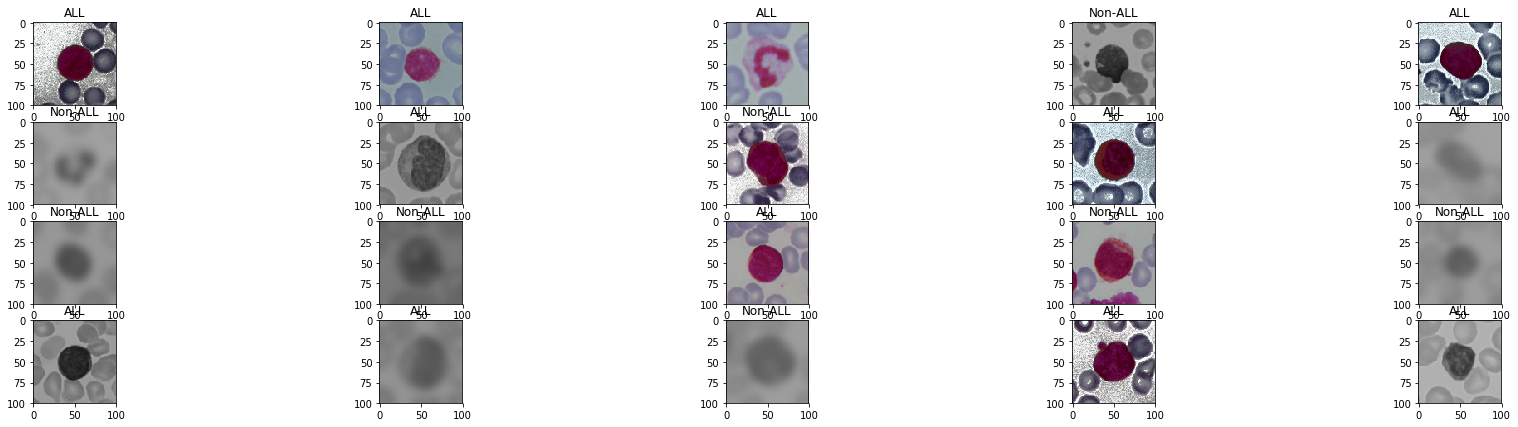

In [0]:
f, ax = plt.subplots(4,5, figsize=(30,7))
for i in range(0,20):
    ax[i//5, i%5].imshow(Data[i])
    if y[i]==1:
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        ax[i//5, i%5].set_title("ALL")

## **Splitting into training and test set**

In [0]:
(X, y) = (data_list[0],data_list[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

## Replicating The Model
The following model was used in the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") paper, additionaly three dropout layers with different dropout rates have been used to reduce overfitting.

In [0]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))

model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))

W0724 19:56:28.391399 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 19:56:28.395263 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 19:56:28.398960 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 19:56:28.414140 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 19:56:28.416520 139762540324736 deprecation_wrapp

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
__________

### Model compilation and fitting

In [0]:
batch_size = 100
epochs= 300

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

W0724 19:56:35.583545 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 19:56:35.592297 139762540324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0724 19:56:35.599432 139762540324736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/300
18/18 [==============================] - 8s 418ms/step - loss: 0.7205 - acc: 0.5058 - precision: 0.5078 - recall: 0.5115
Epoch 2/300
18/18 [==============================] - 7s 407ms/step - loss: 0.6999 - acc: 0.5052 - precision: 0.5071 - recall: 0.5158
Epoch 3/300
18/18 [==============================] - 7s 406ms/step - loss: 0.6947 - acc: 0.5137 - precision: 0.5154 - recall: 0.5303
Epoch 4/300
18/18 [==============================] - 7s 408ms/step - loss: 0.6921 - acc: 0.5191 - precision: 0.5203 - recall: 0.5413
Epoch 5/300
18/18 [==============================] - 7s 408ms/step - loss: 0.6907 - acc: 0.5253 - precision: 0.5258 - recall: 0.5576
Epoch 6/300
18/18 [==============================] - 7s 410ms/step - loss: 0.6884 - acc: 0.5359 - precision: 0.5353 - recall: 0.5737
Epoch 7/300
18/18 [==============================] - 7s 412ms/step - loss: 0.6846 - acc: 0.5521 - precision: 0.5511 - recall: 0.5824
Epoch 8/300
18/18 [==============================] - 7s 413ms/step - 

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.2491266246025379,
 0.9081196571007754,
 0.9308755756078915,
 0.8782608691833649]

In [0]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred)

0.968551333576909

**Result for 300 epochs**

**1.Accuracy -91%**

**2.Precision -0.93**

**3.Recall -0.88**

**4. AUC score -0.97**

The model stops learning after 300 epochs



### Visualizing accuracy and loss

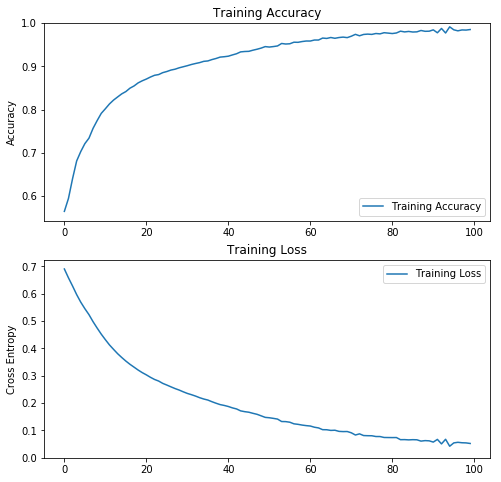

In [0]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

## Saving model into ".json" format

In [0]:
with open("model.json", "w") as file:
    file.write(model.to_json())
model.save_weights("weights.h5")

## Convert model to Tensorflow
Turning Keras model into Tensorflow since Movidius NCS compiles Tensorflow or Caffe models only

In [0]:
from keras.models import model_from_json
from keras import backend as K
import tensorflow as tf

model_file = "model.json"
weights_file = "weights.h5"

with open(model_file, "r") as file:
    config = file.read()

K.set_learning_phase(0)
model = model_from_json(config)
model.load_weights(weights_file)

saver = tf.train.Saver()
sess = K.get_session()
saver.save(sess, "./TF_Model/tf_model")

fw = tf.summary.FileWriter('logs', sess.graph)
fw.close()

In [0]:
keras.models.save_model(model,weights_file)

## Convert to TFLite
Converting the model into tensorflow lite so that it can run on embedded systems 

In [0]:
converter = tf.lite.TocoConverter.from_keras_model_file(weights_file)
tflite_model = converter.convert()

W0724 19:59:06.432994 139762540324736 deprecation.py:323] From <ipython-input-19-b7fadcd17f69>:1: TocoConverter.from_keras_model_file (from tensorflow.lite.python.lite) is deprecated and will be removed in a future version.
Instructions for updating:
Use `lite.TFLiteConverter.from_keras_model_file` instead.
W0724 19:59:06.597624 139762540324736 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0724 19:59:06.614048 139762540324736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0724 19:59:06.614983 139762540324736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (

In [0]:
open("weights.tflite","wb").write(tflite_model)

429272

In [0]:
tflite_models_dir = Path("weights.tflite")

In [0]:
tflite_models_dir.write_bytes(tflite_model)

429272

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_models_dir))
interpreter.allocate_tensors()

## Convert model to quantised TFLite
Converting the model into 8 bit quantised tensorflow lite version

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.post_training_quantize = True

In [0]:
tflite_quant_model = converter.convert()

In [0]:
tflite_models_dir.write_bytes(tflite_quant_model)

109368

We can see that the quantised version consumes approximately 1/4th of the memory consumed by non-quantised version

In [0]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_models_dir))
interpreter_quant.allocate_tensors()

## Evaluate TFLite versions
The following two code snippets are to evaluate the tensorflow lite non-quantised and quantised versions. These worked well for the first time and gave similar outputs(which shows that the precision loss when converting to quantised version is not much and is still accurate).

After that, these two cells are crashing without giving error log and according to tensorflow-lite github issues, it seems that there have been a couple of cases where the tflite interpreter crashes when running on web server.

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#input_data = np.array(X_test)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [0]:
# Get input and output tensors.
input_details = interpreter_quant.get_input_details()
output_details = interpreter_quant.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#input_data = np.array(X_test[0])
interpreter_quant.set_tensor(input_details[0]['index'], input_data)

interpreter_quant.invoke()
output_data = interpreter_quant.get_tensor(output_details[0]['index'])
print(output_data)

## Obtain accuracy & evaluate model
This is to obtain accuracy and evaluate the model over a number of images in the dataset

In [0]:
def eval_model(interpreter, train_data):
  total_seen = 0
  num_correct = 0

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  for img, label in train_data:
    total_seen += 1
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if predictions == label.numpy():
      num_correct += 1

    if total_seen % 500 == 0:
      print("Accuracy after %i images: %f" %
            (total_seen, float(num_correct) / float(total_seen)))

  return float(num_correct) / float(total_seen)

In [0]:
print(eval_model(interpreter, train_data))

In [0]:
print(eval_model(interpreter_quant, train_data))

## Neural Compute Stick

This is the compilation command to be written on command line tool provided with Neural Compute Stick SDK toolkit

In [0]:
# compilation command
#mvNCCompile TF_Model/tf_model.meta -in=conv2d_1_input -on=dense_1/Softmax

mvNCCompile tflite_quant_model -in=conv2d_1_input -on=dense_1/Softmax

### Deploying the graph on Neural Compute Stick to make an inference

In [0]:
from mvnc import mvncapi as mvnc
# get the first NCS device by its name. 
devices = mvnc.enumerate_devices()
# get the first NCS device by its name.  
dev = mvnc.Device(devices[0])
# Read a compiled network graph from file (set the graph_filepath correctly for your graph file)
with open("graph", mode='rb') as f:
    graphFileBuff = f.read()

graph = mvnc.Graph('graph1')

# Allocate the graph on the device and create input and output Fifos
in_fifo, out_fifo = graph.allocate_with_fifos(dev, graphFileBuff)

# Write the input to the input_fifo buffer and queue an inference in one call
graph.queue_inference_with_fifo_elem(in_fifo, out_fifo, input_img.astype('float32'), 'user object')

# Read the result to the output Fifo
output, userobj = out_fifo.read_elem()
print('Predicted:',output.argmax())

# Contributing

The Peter Moss Acute Myeloid & Lymphoblastic Leukemia AI Research project encourages and welcomes code contributions, bug fixes and enhancements from the Github.

Please read the [CONTRIBUTING](https://github.com/AMLResearchProject/AML-ALL-Classifiers/blob/master/CONTRIBUTING.md "CONTRIBUTING") document for a full guide to forking our repositories and submitting your pull requests. You will also find information about our code of conduct on this page.

## Acute Myeloid & Lymphoblastic Leukemia Classifiers Contributors

- [Adam Milton-Barker](https://github.com/AdamMiltonBarker "Adam Milton-Barker") - Bigfinite IoT Network Engineer & Intel Software Innovator, Barcelona, Spain
- [Salvatore Raieli](https://github.com/salvatorera "Salvatore Raieli") - PhD Immunolgy / Bioinformaticia, Bologna, Italy
- [Dr Amita Kapoor](https://github.com/salvatorera "Dr Amita Kapoor") - Delhi University, Delhi, India

&nbsp;

# Versioning

We use SemVer for versioning. For the versions available, see [Releases](https://github.com/AMLResearchProject/AML-ALL-Classifiers/releases "Releases").

# License

This project is licensed under the **MIT License** - see the [LICENSE](https://github.com/AMLResearchProject/AML-ALL-Classifiers/blob/master/LICENSE "LICENSE") file for details.

# Bugs/Issues

We use the [repo issues](https://github.com/AMLResearchProject/AML-ALL-Classifiers/issues "repo issues") to track bugs and general requests related to using this project.
